# Librairies and functions

In [2]:
import numpy as np
import pandas as pd
import igraph as ig
from collections import Counter
import matplotlib.pyplot as plt
import json, re, gc, requests
from tqdm import tqdm

In [ ]:
path_input = r'/my/path/input'
path_output = r'/my/path/output'

# Open the main files

- `Papers_neuroscience_all.json` 
- `Papers_neuroscience_and_AI.json`
- `papers_QL2.csv`
- `citationNetwork.csv`
- `WOSjr.csv`
- `AI_kw_classification.txt`
- `author_paper_QL0+QL2.csv`
- `authorId_name_affiliation_QL0+QL1.csv`
- `Paper_abstracts_Neuroscience.json`
- `PaperFieldsOfStudy_simplified.txt`

#### Read the whole large database of neuroscience papers

Available under reasonable demand

In [5]:
with open(f'{path_input}Papers_neuroscience_all.json', 'r') as f:
    data = json.load(f)
data = pd.DataFrame.from_dict(data)

In [7]:
data.columns

Index(['id', ' publicationDate', ' issueIdentifier', ' created', ' publisher',
       ' volume', ' startingPage', ' endingPage', ' citationCount', ' doi',
       ' title', ' referenceCount', ' appearsInJournal', 'queryLevel',
       'authors', ' bookTitle', ' appearsInConferenceSeries',
       ' appearsInConferenceInstance'],
      dtype='object')

#### Read the whole citation network containing no isolated nodes, ie. total degree $\neq$ 0
Here one citation link is directed such that 'citing' is 'source' and 'cited' is 'target'

In [ ]:
CN = ig.Graph.DataFrame(pd.read_csv(f'{path_input}citationNetwork.csv', sep=',', usecols=['citing', 'cited']), directed=True)
nodes = [CN.vs[i]['name'] for i in range(len(CN.vs))]

# Build a global egocentered dataset for citation network study
Build a subdataframe containing only papers containing at least one edge (coming inside or outside) in the whole citation network. We consider here only first 'in' and 'out' level of citation.

The index "queryLevel" index indicates here the presence of a given article inside the originally extracted neuroscience dataset (value 0, egocentered) or not (value 1, those added for the citation network).

In [10]:
subdata = data[['id', 'queryLevel', ' title',' publicationDate', ' appearsInJournal', 'authors']].reset_index(drop=True)
subdata.rename(columns = {' publicationDate': 'publicationYear', ' appearsInJournal': 'idJournal', ' title':'title'}, inplace=True)
#subdata['title'] = subdata['title'].apply(lambda x: eval(x))
subdata['publicationYear'].fillna('-1', inplace=True)
subdata['publicationYear'] = [int(re.findall(r'\d+', i)[0]) if i != '-1' else -1 for i in subdata['publicationYear']]
subdata['idJournal'].fillna(-1, inplace=True)
subdata['idJournal'] = [int(i) if i != -1 else -1 for i in subdata['idJournal']]
subdata

,id,queryLevel,title,publicationYear,idJournal,authors
0,2038431747,0,"""Topology learning solved by extended objects...",1994,207023548,"[2163422316, 2419355596, 2289589767]"
1,1010827267,0,"""Multipotent Stem Cells In Murine Sclera""",2011,76304953,"[2482935619, 2618323644, 2661080946, 266108094..."
2,2411724805,0,"""Comparative study on results of prefrontal l...",1953,124451323,"[2987759242, 2631162769, 2651065461]"
3,2004877318,0,"""Ventral frontal deficits in psychopathy: Neu...",1995,165368631,"[2572627602, 2278535667, 2800225512]"
4,2025848838,0,"""Iowa gambling task in Parkinson&#039",2011,35508115,"[237217217, 2129310074, 2647734675]"
...,...,...,...,...,...,...
14028712,2080374763,1,"""The spectral sensitivity of light-adapted ca...",1954,2090548,[2684787159]
14028713,2147483632,1,"""The 5-hydroxytryptamine (serotonin) receptor...",2013,136368880,"[2145232497, 2336850026, 2671773241, 144628305..."
14028714,2181038068,1,"""Giving machines humanlike eyes""",2015,66124381,"[2974799061, 2723812261, 2617766515]"
14028715,2147483638,1,"""Effect of three anaesthetic techniques on is...",2004,33418846,"[2308317210, 2070658732, 2496673173, 2930434804]"


## Add journals' name and associated discipline from WoS classification

In [2]:
def wos_split_strings(list_str):
    l = []
    for i in list_str:
        l += re.split(' \| ', i) # change separators if needed
    return l

In [12]:
# read the WoS disciplinary classification and add it to the journals database
JournalsDisciplines = pd.read_csv(f'{path_input}WOSjr.csv', sep=';')
JournalsDisciplines.rename(columns={'MAG_journal_Id': 'idJournal'}, inplace=True)
JournalsDisciplines = JournalsDisciplines.groupby('idJournal').agg(lambda x: x.tolist()).reset_index()
JournalsDisciplines['Web of Science Categories'] = [wos_split_strings(i) for i in JournalsDisciplines['Web of Science Categories']]
JournalsDisciplines

,idJournal,Journal title,Web of Science Categories
0,61661,[JOURNAL OF PROSTHODONTICS-IMPLANT ESTHETIC AN...,"[Dentistry, Oral Surgery & Medicine]"
1,81127,[EUROPEAN HEART JOURNAL SUPPLEMENTS],[Cardiac & Cardiovascular System]
2,146344,[JOURNAL OF MARRIAGE AND FAMILY],"[Sociology, Family Studies]"
3,161885,[CHINESE STUDIES IN HISTORY],"[History, Asian Studies]"
4,182001,[GIFTED CHILD QUARTERLY],"[Psychology, Educational, Education, Special]"
...,...,...,...
17605,3035668652,[EUROPEAN RADIOLOGY EXPERIMENTAL],"[Radiology, Nuclear Medicine & Medical Imaging]"
17606,3035671286,[SATELLITE NAVIGATION],"[Engineering, Aerospace, Telecommunications, R..."
17607,3035730399,[JOURNAL OF THE EGYPTIAN PUBLIC HEALTH ASSOCIA...,"[Public, Environmental & Occupational Health]"
17608,3035751226,[JOURNAL OF PATIENT-REPORTED OUTCOMES],"[Health Care Sciences & Services, Health Polic..."


In [13]:
subdata = pd.merge(subdata, JournalsDisciplines, on='idJournal', how='left')
subdata.rename(columns={'Journal title': 'journal_title', 'Web of Science Categories': 'wos_domains'}, inplace=True)

## Add AI keywords and main classes if 'isIA=1'

In [15]:
# read intersection dataset neuro and IA
with open(f'{path_input}Papers_neuroscience_and_IA.json', 'r') as f:
    dataIA = json.load(f)
dataIA = pd.DataFrame.from_dict(dataIA)

In [56]:
dataIA

,id,publicationDate,issueIdentifier,created,publisher,volume,startingPage,endingPage,citationCount,doi,title,referenceCount,appearsInJournal,queryLevel,authors,bookTitle,appearsInConferenceSeries,appearsInConferenceInstance,abstract,keywordsIA
0,2982150161,"""2020-03-07""",NaN,"""2019-11-01""","""Elsevier""","""380""","""11""","""19""","""1""",10.1016/J.NEUCOM.2019.10.001,"""Delay tolerant containment control for secon...","""32""",45693802,0,"[2698853177, 2894619631, 2090493536, 2980724061]",NaN,NaN,NaN,"Abstract In this paper, a delay tolerant cont...","[convex hull, multi-agent system]"
1,2017460423,"""2004-12-01""","""4""","""2016-06-24""","""Lippincott Williams and Wilkins""","""14""","""187""","""189""","""0""",10.1097/00041444-200412000-00003,"""Evaluation of genetic substructure in the Ir...","""0""",41645954,0,"[2494464687, 2120665394, 2091809267, 2614997734]",NaN,NaN,NaN,: The presence of genetic substructure has th...,[markov chain monte carlo]
2,2592080110,"""2017-03-03""",NaN,"""2017-03-16""","""Dove Press""","""9""","""39""","""57""","""36""",10.2147/NSS.S103467,"""New developments in the management of narcol...","""0""",2739268901,0,"[2162133358, 2136137024]",NaN,NaN,NaN,": Narcolepsy is a life-long, underrecognized ...",[mycin]
3,2613051638,"""2017-07-01""",NaN,"""2017-05-19""","""Elsevier""","""158""","""7""","""13""","""0""",10.1016/J.PBB.2017.05.004,"""Posterior hypothalamus glutamate infusion de...","""51""",59685179,0,"[2049946654, 2108670995, 2944770929, 2667938519]",NaN,NaN,NaN,Abstract Objectives Seizures are epileptic ma...,[lenet]
4,2617245985,"""2017-11-29""",NaN,"""2017-06-05""","""Elsevier""","""266""","""325""","""335""","""15""",10.1016/J.NEUCOM.2017.05.042,"""Deep learning algorithms for discriminant au...","""36""",45693802,0,"[3024761849, 2619442247]",NaN,NaN,NaN,"In this paper, a new family of Autoencoders (...","[autoencoder, dimensionality reduction]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
614353,1979711143,"""1998-07-24""","""3""","""2016-06-24""","""ACM""","""37""","""209""","""217""","""937""",10.1145/279943.279985,"""Large margin classification using the percep...","""21""",NaN,1,"[2985572601, 2626311920]","""COLT""",1177622950,2786194060,We introduce and analyze a new algorithm for ...,[classifier]
614354,2147483361,"""2011-04-01""","""4""","""2016-06-24""","""IEEE""","""33""","""754""","""766""","""137""",10.1109/TPAMI.2010.133,"""Harvesting Image Databases from the Web""","""26""",199944782,1,"[2985357453, 1966707555, 2469405535]",NaN,NaN,NaN,The objective of this work is to automaticall...,"[training data, classifier]"
614355,2919235374,"""2019-05-01""",NaN,"""2019-03-11""","""Academic Press""","""61""","""42""","""49""","""2""",10.1016/J.JVCIR.2019.03.004,"""Application of artificial intelligence algor...","""24""",105424869,1,"[2919870832, 2919889170]",NaN,NaN,NaN,Abstract As the main media of human communica...,"[artificial intelligence, combinatorial optimi..."
614356,2046820148,"""2014-03-20""","""3""","""2016-06-24""","""Public Library of Science""","""9""",NaN,NaN,"""52""",10.1371/JOURNAL.PONE.0091969,"""Visceral adiposity index (VAI) is predictive...","""41""",202381698,1,"[45745419, 1900658159, 3005837255, 2080409075,...",NaN,NaN,NaN,Aims Although there is still no clear definit...,[cluster analysis]


In [67]:
# read the classification of AI keywords
classification = pd.read_csv(f'{path_input}AI_kw_classification.txt', sep=';', names=['keywords', 'class'])
classification['keywords'] = [i.strip() for i in classification['keywords']]
classification

,keywords,class
0,evolutionary algorithm,optimization
1,simulated annealing,optimization
2,hierarchical clustering,cluster analysis
3,principal component analysis,cluster analysis
4,unsupervised learning,machine learning
...,...,...
527,multi swarm optimization,optimization
528,fast and frugal trees,AI general
529,chess playing computer,robotics
530,bias variance tradeoff,optimization


In [17]:
dataIA['classIA'] = (dataIA['keywordsIA'].apply(
    lambda x: list(set([classification[classification['keywords']==k]['class'].values[0] for k in x if len(classification[classification['keywords']==k]['class'].values) != 0]))))

In [17]:
subdata['isIA'] = np.where(subdata['id'].isin(dataIA['id']), 1, 0)
subdata = pd.merge(subdata, dataIA[['id', 'keywordsIA', 'classIA']], on='id', how='left').fillna(-1)
subdata

,id,queryLevel,title,publicationYear,idJournal,authors,isIA
0,2038431747,0,"""Topology learning solved by extended objects...",1994,207023548,"[2163422316, 2419355596, 2289589767]",0
1,1010827267,0,"""Multipotent Stem Cells In Murine Sclera""",2011,76304953,"[2482935619, 2618323644, 2661080946, 266108094...",0
2,2411724805,0,"""Comparative study on results of prefrontal l...",1953,124451323,"[2987759242, 2631162769, 2651065461]",0
3,2004877318,0,"""Ventral frontal deficits in psychopathy: Neu...",1995,165368631,"[2572627602, 2278535667, 2800225512]",0
4,2025848838,0,"""Iowa gambling task in Parkinson&#039",2011,35508115,"[237217217, 2129310074, 2647734675]",0
...,...,...,...,...,...,...,...
14028712,2080374763,1,"""The spectral sensitivity of light-adapted ca...",1954,2090548,[2684787159],0
14028713,2147483632,1,"""The 5-hydroxytryptamine (serotonin) receptor...",2013,136368880,"[2145232497, 2336850026, 2671773241, 144628305...",0
14028714,2181038068,1,"""Giving machines humanlike eyes""",2015,66124381,"[2974799061, 2723812261, 2617766515]",0
14028715,2147483638,1,"""Effect of three anaesthetic techniques on is...",2004,33418846,"[2308317210, 2070658732, 2496673173, 2930434804]",0


In [334]:
del dataIA

## Save the final subdataframe

In [39]:
subdata.to_csv(f"{path_output}citationNetwork_nodes.csv", sep=';', index=False)
# del subdata

# Build filtered egocentered datasets for $\mathcal{P}\cap AI$ and $\mathcal{P}\cap \overline{AI}$
It includes papers with main attributes:
- `queryLevel=0`
- published after 1970
- cited at least 10 times, ie. $k_{in}>=10$
- citing at least 10 other references, ie. $k_{out}>=10$

### $\mathcal{P}\cap \overline{AI}$

Here `isIA=0`

In [12]:
data.fillna(-1, inplace=True)
data[' referenceCount'] = data[' referenceCount'].apply(lambda x: int(eval(x)) if x!=-1 else -1)
data[' citationCount'] = data[' citationCount'].apply(lambda x: int(eval(x)) if x!=-1 else -1)

In [42]:
# get only the ids of the papers that counts at least 10 reference and citation
ids_nbRefSup10nbImpSup10 = data[(data[' referenceCount'] >= 10)
                                & (data[' citationCount'] >= 10)]['id']

In [43]:
subdata_subset = subdata[(subdata['queryLevel']==0) 
                    & (subdata['isIA']==0) 
                    & (subdata['publicationYear']>=1970) # & (subdata['publicationYear']<2020) 
                    & (subdata['id'].isin(ids_nbRefSup10nbImpSup10))]

In [44]:
len(subdata_subset) # here 829317

829317

In [53]:
subdata_subset.to_csv(f"{path_output}papersNeuro_minRef10_minImp10_from1970.csv", sep=';', index=False)

In [8]:
# force to free memory
del data, CN, nodes
gc.collect()

0

### $\mathcal{P}\cap AI$

Here `isIA=1`

In [13]:
ids_nbRefSup10nbImpSup10 = data[(data[' referenceCount'] >= 10)
                                & (data[' citationCount'] >= 10)]['id']

In [25]:
subdata_subset = subdata[(subdata['queryLevel']==0) 
                    & (subdata['isIA']==1) 
                    & (subdata['publicationYear']>=1970) # & (subdata['publicationYear']<2020) 
                    & (subdata['id'].isin(ids_nbRefSup10nbImpSup10))]

In [50]:
len(subdata_subset) # here 26374

26374

In [54]:
subdata_subset.to_csv(f"{path_output}papersNeuroAI_minRef10_minImp10_from1970.csv", sep=';', index=False)

# Add the abstracts

In [3]:
# only papers in qeryLevel=0, published since 1970 and that have at least 10 references and 10 impacts
papersAI = pd.read_csv(f"{path_output}papersNeuroAI_minRef10_minImp10_from1970.csv", sep=';')
papersNonAI = pd.read_csv(f"{path_output}filtered_data_for_analyzes/papersNeuro_minRef10_minImp10_from1970.csv", sep=';')

## Do with the original extracted file from (Zenodo?)...

In [5]:
with open(f'{path_input}Paper_abstracts_Neuroscience.json','r') as bf:
    abstracts = json.load(bf)
abstracts = pd.DataFrame.from_records(abstracts)
abstracts.rename(columns={'paperId':'id'},inplace=True)

In [6]:
papersAI = pd.merge(papersAI, abstracts[abstracts['id'].isin(papersAI['id'])], on='id', how='left')
papersNonAI = pd.merge(papersNonAI, abstracts[abstracts['id'].isin(papersNonAI['id'])], on='id', how='left')

In [7]:
papersAI.to_csv(f"{path_output}papersNeuroAI_minRef10_minImp10_from1970_WITHABSTRACTS.csv", sep='\t', index=False)
papersNonAI.to_csv(f"{path_output}papersNeuro_minRef10_minImp10_from1970_WITHABSTRACTS.csv", sep='\t', index=False)

## ... Or scrap it with OpenAlex

In [133]:
# from the key 'abstract_inverted_index' key per paper
def rebuild_abstract(word_dict):
    if word_dict != None:
        # search the highest index
        max_index = 0
        for ind in word_dict.values():
            local_max = max(ind)
            if local_max > max_index:
                max_index = local_max
        abstract = ['']*(max_index+1)
        for i in word_dict.keys():
            for j in word_dict[i]:
                abstract[j] = i
        abstract = ' '.join(abstract)
        return abstract
    else:
        return('')

def scrap_title_and_abstracts_from_MAGIDs_df(papers):
    is_work = 'https://api.openalex.org/works?'
    authentification = 'mailto=myemail@adress.com'
    #filtering = 'filter=has_doi:true,has_abstract:true,has_references:true,ids.mag:' # for articles having a doi, an abstract and at least one reference
    filtering = 'filter=ids.mag:'
    results_per_page = 'per-page=100'
    cursor = 'cursor=*'
    baseURL = '&'.join([is_work,
                        authentification,
                        results_per_page,
                        cursor,
                        filtering])
    # filter by MAG ID
    # API allows only up to 50 ids or filtering items per request
    # API stops the request after 10 subsequent seconds of requests
    new_metadata = []
    k = 0
    ids = list(papers['id'])
    pbar = tqdm(total=len(ids))
    while k < len(papers['id']):
        ids = ids[k:k+50]
        apiurl = baseURL + '|'.join(list(map(lambda x: str(x), ids[k:k+50])))
        articles = requests.get(apiurl).json()['results']
        if cc:
            new_metadata += [(int(a['ids']['mag']), a['title'], rebuild_abstract(a['abstract_inverted_index']))
                             for a in articles]
        k += 50
        pbar.update(50)
    pbar.close()
    
    return new_metadata

### $\mathcal{P}\cap AI$ dataset

In [128]:
titles_and_abstracts_AI = scrap_title_and_abstracts_from_MAGIDs_df(papersAI)

  1%|▍                                    | 300/26374 [00:47<1:08:59,  6.30it/s]
26400it [10:50, 40.56it/s]                                                      


In [130]:
papersAI = pd.merge(papersAI, pd.DataFrame(titles_and_abstracts_AI, columns=['id','title','abstract']), on='id', how='left')
papersAI

,id,queryLevel,publicationYear,idJournal,authors,journal_title,wos_domains,isIA,keywordsIA,classIA,title,abstract
0,2617245985,0,2017,45693802,"[3024761849, 2619442247]",['NEUROCOMPUTING'],"['Computer Science, Artificial Intelligence']",1,"['autoencoder', 'dimensionality reduction']","['deep learning', 'cluster analysis']",Deep learning algorithms for discriminant auto...,"In this paper, a new family of Autoencoders (A..."
1,2021655074,0,2006,140962798,"[2145260682, 2835622326]",['NEURAL PROCESSING LETTERS'],"['Computer Science, Artificial Intelligence']",1,"['perceptrons', 'backpropagation']",['neural networks'],CB3: An Adaptive Error Function for Backpropag...,
2,1790968754,0,2015,207023548,"[2798335766, 2995834608, 2891704168, 2651595071]",['NEURAL COMPUTATION'],"['Neurosciences', 'Computer Science, Artificia...",1,['principal component analysis'],['cluster analysis'],Relations Among Some Low-Rank Subspace Recover...,Recovering intrinsic low-dimensional subspaces...
3,2067792927,0,2004,5555990,"[1907317825, 2810474215, 2569059621]",['JOURNAL OF NEUROSCIENCE'],['Neurosciences'],1,['mycin'],['AI general'],Memory-Like Alterations in Aplysia Axons after...,"Adaptive, long-term alterations of excitabilit..."
4,2076181669,0,2009,38337076,"[27505624, 251582393, 2148513875, 1975445839, ...",['CLINICAL NEUROPHYSIOLOGY'],"['Clinical Neurology', 'Neurosciences']",1,['f score'],['NLP'],Cortical sources of resting-state alpha rhythm...,High power of pre-stimulus cortical alpha rhyt...
...,...,...,...,...,...,...,...,...,...,...,...,...
26369,2315255150,0,2013,121278948,"[276387308, 2763921609]",['NEUROREPORT'],['Neurosciences'],1,['face recognition'],['face recognition'],Time course of brain activation elicited by ba...,Whereas facial emotion recognition protocols h...
26370,2021654198,0,2013,117312820,"[1455697005, 3017137108, 2037379488, 203737948...",['AGEING RESEARCH REVIEWS'],"['Geriatrics & Gerontology', 'Cell Biology']",1,['pattern recognition'],['classification'],Pathogenesis of acute stroke and the role of i...,Inflammation is an innate immune response to i...
26371,2311061258,0,2016,103225281,"[1977871830, 2806397737, 2895902604, 229045898...",['NEUROIMAGE'],"['Neuroimaging', 'Radiology, Nuclear Medicine ...",1,['f-score'],['NLP'],Characterising brain network topologies: A dyn...,Network theory provides a principled abstracti...
26372,2235563853,0,1998,142952003,"[2126595957, 2769246520]",['JOURNAL OF NEUROPHYSIOLOGY'],"['Physiology', 'Neurosciences']",1,['mycin'],['AI general'],Recovery of Semicircular Canal Primary Afferen...,"Li, Weidong and Manning J. Correia. Recovery o..."


In [132]:
papersAI.to_csv(f"{path_output}papersNeuroAI_minRef10_minImp10_from1970_WITHABSTRACTS.csv", sep='\t', index=False)
papersAI.loc[:10,:].to_csv(f"{path_output}papersNeuroAI_minRef10_minImp10_from1970_WITHABSTRACTS_10firstlines.csv", sep='\t', index=False)

### $\mathcal{P}\cap \overline{AI}$ dataset

In [ ]:
titles_and_abstracts_nonAI = scrap_title_and_abstracts_from_MAGIDs_df(papersNonAI)

In [130]:
papersAI = pd.merge(papersNonAI, pd.DataFrame(titles_and_abstracts_nonAI, columns=['id','title','abstract']), on='id', how='left')
papersAI

,id,queryLevel,publicationYear,idJournal,authors,journal_title,wos_domains,isIA,keywordsIA,classIA,title,abstract
0,2617245985,0,2017,45693802,"[3024761849, 2619442247]",['NEUROCOMPUTING'],"['Computer Science, Artificial Intelligence']",1,"['autoencoder', 'dimensionality reduction']","['deep learning', 'cluster analysis']",Deep learning algorithms for discriminant auto...,"In this paper, a new family of Autoencoders (A..."
1,2021655074,0,2006,140962798,"[2145260682, 2835622326]",['NEURAL PROCESSING LETTERS'],"['Computer Science, Artificial Intelligence']",1,"['perceptrons', 'backpropagation']",['neural networks'],CB3: An Adaptive Error Function for Backpropag...,
2,1790968754,0,2015,207023548,"[2798335766, 2995834608, 2891704168, 2651595071]",['NEURAL COMPUTATION'],"['Neurosciences', 'Computer Science, Artificia...",1,['principal component analysis'],['cluster analysis'],Relations Among Some Low-Rank Subspace Recover...,Recovering intrinsic low-dimensional subspaces...
3,2067792927,0,2004,5555990,"[1907317825, 2810474215, 2569059621]",['JOURNAL OF NEUROSCIENCE'],['Neurosciences'],1,['mycin'],['AI general'],Memory-Like Alterations in Aplysia Axons after...,"Adaptive, long-term alterations of excitabilit..."
4,2076181669,0,2009,38337076,"[27505624, 251582393, 2148513875, 1975445839, ...",['CLINICAL NEUROPHYSIOLOGY'],"['Clinical Neurology', 'Neurosciences']",1,['f score'],['NLP'],Cortical sources of resting-state alpha rhythm...,High power of pre-stimulus cortical alpha rhyt...
...,...,...,...,...,...,...,...,...,...,...,...,...
26369,2315255150,0,2013,121278948,"[276387308, 2763921609]",['NEUROREPORT'],['Neurosciences'],1,['face recognition'],['face recognition'],Time course of brain activation elicited by ba...,Whereas facial emotion recognition protocols h...
26370,2021654198,0,2013,117312820,"[1455697005, 3017137108, 2037379488, 203737948...",['AGEING RESEARCH REVIEWS'],"['Geriatrics & Gerontology', 'Cell Biology']",1,['pattern recognition'],['classification'],Pathogenesis of acute stroke and the role of i...,Inflammation is an innate immune response to i...
26371,2311061258,0,2016,103225281,"[1977871830, 2806397737, 2895902604, 229045898...",['NEUROIMAGE'],"['Neuroimaging', 'Radiology, Nuclear Medicine ...",1,['f-score'],['NLP'],Characterising brain network topologies: A dyn...,Network theory provides a principled abstracti...
26372,2235563853,0,1998,142952003,"[2126595957, 2769246520]",['JOURNAL OF NEUROPHYSIOLOGY'],"['Physiology', 'Neurosciences']",1,['mycin'],['AI general'],Recovery of Semicircular Canal Primary Afferen...,"Li, Weidong and Manning J. Correia. Recovery o..."


In [132]:
papersNonAI.to_csv(f"{path_output}papersNeuro_minRef10_minImp10_from1970_WITHABSTRACTS.csv", sep='\t', index=False)

# Add concepts of MAG

In [234]:
chunksize = 10000000
df = pd.DataFrame()
ids = list(papersAI['id'])+list(papersNonAI['id'])
for chunk in tqdm(pd.read_csv(f'{path_input}PaperFieldsOfStudy_simplified.txt',
                         sep=';', chunksize=chunksize, engine='c', low_memory=True)):
    df = pd.concat([df,chunk[chunk['paper'].isin(ids)]])
df = df.groupby('paper').agg(list).reset_index().rename(columns={'paper':'id','discipline':'concept'})

141it [03:59,  1.70s/it]


In [241]:
df

,id,concept
0,763,"[86803240, 105702510, 111337013, 14112920, 676..."
1,32177,"[15744967, 118552586, 2780405171, 2779158372, ..."
2,51529,"[2776521421, 105702510, 205260736, 2908626383,..."
3,91107,"[93877712, 112952253, 2780191927, 126322002, 1..."
4,96735,"[541997718, 93877712, 86803240, 105702510, 142..."
...,...,...
855686,3028283073,"[86803240, 55493867, 143191323, 2986115478, 27..."
855687,3028310892,"[105702510, 2777085867, 86803240, 6757342, 301..."
855688,3028346786,"[86803240, 55493867, 40465926, 95444343, 30177..."
855689,3028484652,"[71924100, 1862650, 142724271, 2777893043]"


In [245]:
papersAI = pd.merge(papersAI,df,on='id',how='inner')
papersNonAI = pd.merge(papersNonAI,df,on='id',how='inner')

In [247]:
papersAI.to_csv(f"{path_output}papersNeuroAI_minRef10_minImp10_from1970_WITHABSTRACTS.csv", sep='\t', index=False)
papersNonAI.to_csv(f"{path_output}papersNeuro_minRef10_minImp10_from1970_WITHABSTRACTS.csv", sep='\t', index=False)

# Build an egocentered collaboration network based on all publications (not only in neurosciences) of the authors
- Build a dataset of authors authors of the papers included in the set of neuroscience papers $\mathcal{P}$ (query level 0), based on all their publications, included those that are not in $\mathcal{P}$ (query level 2, extracted as well).
- Build a collaboration network centered on these authors.

## Build the author database
Since many files are used for the process, we recall here the basic steps for building such a database:
1) Get the authors from the neuroscience egocentered database (QL0), called `all_papers_QL0` in the following

2) Get their informations (name and affilitations) from a file imported under the variable `allAuthors_Ql0Ql1`

3) In order to compute their AI score overall their publications, add to the database QL0 the paper published by these authors but not inside QL0, saved in the file loaded under the variable `allpapers_Ql2` in the following. Then compute the AI score.

#### Step 1

In [5]:
# only papers in qeryLevel=0, published since 1970 and that have at least 10 references and 10 impacts
papersAI = pd.read_csv(f"{path_output}papersNeuroAI_minRef10_minImp10_from1970.csv", sep=';')
papersNonAI = pd.read_csv(f"{path_output}papersNeuro_minRef10_minImp10_from1970.csv", sep=';')

In [6]:
allpapers_QL0 = pd.concat([papersAI,papersNonAI]).reset_index(drop=True)
allpapers_QL0['authors'] = [list(set(eval(i))) if i!='-1' else -1 for i in allpapers_QL0['authors']] # to avoid the double apparitions
allpapers_QL0['journal_title'] = [list(set(eval(i))) if i!='-1' else -1 for i in allpapers_QL0['journal_title']] # idem
allpapers_QL0['wos_domains'] = [list(set(eval(i))) if i!='-1' else -1 for i in allpapers_QL0['wos_domains']] # idem
allpapers_QL0['wos_domains_agg'] = allpapers_QL0['wos_domains'].apply(lambda x: list(set([i.split(', ')[0] for i in x])) if x!=-1 else -1)
allpapers_QL0['keywordsIA'] = [list(set(eval(i))) if i!=-1 else -1 for i in allpapers_QL0['keywordsIA']] # idem
allpapers_QL0['classIA'] = [list(set(eval(i))) if i!=-1 else -1 for i in allpapers_QL0['classIA']] # idem

In [6]:
# expand the big dataframe with respect to the authors
allpapers_QL0_expanded = allpapers_QL0.explode('authors').reset_index(drop=True)
allpapers_QL0_expanded

,id,queryLevel,publicationYear,idJournal,authors,journal_title,wos_domains,isIA,keywordsIA,classIA
0,2617245985,0,2017,45693802,3024761849,[NEUROCOMPUTING],"[Computer Science, Artificial Intelligence]",1,"[dimensionality reduction, autoencoder]","[deep learning, cluster analysis]"
1,2617245985,0,2017,45693802,2619442247,[NEUROCOMPUTING],"[Computer Science, Artificial Intelligence]",1,"[dimensionality reduction, autoencoder]","[deep learning, cluster analysis]"
2,2021655074,0,2006,140962798,2145260682,[NEURAL PROCESSING LETTERS],"[Computer Science, Artificial Intelligence]",1,"[backpropagation, perceptrons]",[neural networks]
3,2021655074,0,2006,140962798,2835622326,[NEURAL PROCESSING LETTERS],"[Computer Science, Artificial Intelligence]",1,"[backpropagation, perceptrons]",[neural networks]
4,1790968754,0,2015,207023548,2995834608,[NEURAL COMPUTATION],"[Computer Science, Artificial Intelligence, Ne...",1,[principal component analysis],[cluster analysis]
...,...,...,...,...,...,...,...,...,...,...
4026968,2046820344,0,2012,116196263,2579365867,[CORTEX],"[Psychology, Experimental, Behavioral Sciences...",0,-1,-1
4026969,2046820344,0,2012,116196263,2016899951,[CORTEX],"[Psychology, Experimental, Behavioral Sciences...",0,-1,-1
4026970,2046820344,0,2012,116196263,157945237,[CORTEX],"[Psychology, Experimental, Behavioral Sciences...",0,-1,-1
4026971,2046820344,0,2012,116196263,2496737467,[CORTEX],"[Psychology, Experimental, Behavioral Sciences...",0,-1,-1


#### Step 2

In [8]:
# read the whole authors' dataframe including the authors of our publications (QL0)
# as well as those in references and impact (QL1)
allAuthors_Ql0Ql1 = pd.read_csv(f'{path_input}authorId_name_affiliation_QL0+QL1.csv', sep=',')
allAuthors_Ql0Ql1

,authorId,name,affiliation,queryLevel
0,1990375167,A.A.A.A Kusumawardhani,NONE,1
1,2663910298,A.A.A.A Nasser,NONE,1
2,2814684889,A A A Aarts,99464096,1
3,3020917786,A.A.A. Ahmed,NONE,1
4,2594650676,A. A. A. Aioub,7597260,1
...,...,...,...,...
15325785,2257106621,李哲雨,NONE,1
15325786,2516757462,李桂楨,NONE,1
15325787,2663157117,李永麟,NONE,1
15325788,2668056676,李相哲,NONE,1


In [13]:
# filter the big file for all authors in QL0 (data for neuroscience)
authorsInPapers = allAuthors_Ql0Ql1[allAuthors_Ql0Ql1['authorId'].isin(set(allpapers_QL0_expanded['authors'])-{-1})]
authorsInPapers

,authorId,name,affiliation,queryLevel
41,1550607070,A. A. A. M. Danen-van Oorschot,121797337,0
44,2505675405,A. A. A. Manik J. Djelantik,193662353,0
53,2806045187,A.A.A. Pradhan,5023651,0
72,2974182613,A. A. Aarnisalo,NONE,0
134,2991992674,A A Abdel-Latif,25041050,0
...,...,...,...,...
15262197,2263707641,Е. Viteva,NONE,0
15262570,3022633000,Е Е Garanina,21203515,0
15265271,2688406403,Мikhail Pashenkov,NONE,0
15269510,2495571327,І. L. Popovych,149851306,0


#### Step 3

In [14]:
# open the link file of all authors with all their associated papers (QL0+QL2)
# drop duplicates: only unique link author-paper
allAuthors_Ql0_papers = pd.read_csv(f'{path_input}author_paper_QL0+QL2.csv', sep=',')
allAuthors_Ql0_papers.drop_duplicates(inplace=True)
#allAuthors_Ql0_papers = allAuthors_Ql0_papers.groupby('authorId').aggregate(list)
allAuthors_Ql0_papers

,authorId,paperId
0,2951562659,285
1,2535012878,348
2,2482451074,348
3,2060325654,527
4,2746639708,662
...,...,...
53855474,2785152602,3035763607
53855475,2852722787,3035763695
53855476,2650729909,3035763695
53855477,2159918643,3035763702


In [15]:
# add the total number of publications of the authors above (even those that do not have abstract)
authorsInPapers = authorsInPapers.merge(pd.DataFrame.from_records(list(Counter(allAuthors_Ql0_papers['authorId']).items()), columns=['authorId', 'nb_publi_all']),
                                   on='authorId',
                                   how='outer').fillna(0)
authorsInPapers

,authorId,name,affiliation,queryLevel,nb_publi_all
0,1550607070,A. A. A. M. Danen-van Oorschot,121797337,0,6
1,2505675405,A. A. A. Manik J. Djelantik,193662353,0,11
2,2806045187,A.A.A. Pradhan,5023651,0,1
3,2974182613,A. A. Aarnisalo,NONE,0,2
4,2991992674,A A Abdel-Latif,25041050,0,8
...,...,...,...,...,...
1290136,2263707641,Е. Viteva,NONE,0,1
1290137,3022633000,Е Е Garanina,21203515,0,1
1290138,2688406403,Мikhail Pashenkov,NONE,0,1
1290139,2495571327,І. L. Popovych,149851306,0,1


In [30]:
# open the main file of publication containing all additionnal publication of the authors
allpapers_QL2 = pd.read_csv(f'{path_input}papers_QL2.csv', sep=';').fillna(-1)
allpapers_QL2['wos_domains'] = [list(set(eval(i))) if i!=-1 else -1 for i in allpapers_QL2['wos_domains']]
allpapers_QL2['wos_domains_agg'] = allpapers_QL2['wos_domains'].apply(lambda x: list(set([i.split(', ')[0] for i in x])) if x!=-1 else -1)
allpapers_QL2['journal_title'] =  allpapers_QL2['journal_title'].apply(lambda x: list(set(eval(x)))[0] if x!=-1 else -1)
allpapers_QL2['keywordsIA'] = [list(set(eval(i))) if i!=-1 else -1 for i in allpapers_QL2['keywordsIA']]
allpapers_QL2['classIA'] = [list(set(eval(i))) if i!=-1 else -1 for i in allpapers_QL2['classIA']]
allpapers_QL2['queryLevel'] = 2
allpapers_QL2

,id,publicationYear,title,idJournal,queryLevel,journal_title,wos_domains,isIA,keywordsIA,classIA,wos_domains_agg
0,1984623903,1981,"""F&#x00FC;nf neue Arten der Gattung Halacarus ...",4078192,2,ZOOLOGICA SCRIPTA,"[Evolutionary Biology, Zoology]",0,-1,-1,"[Evolutionary Biology, Zoology]"
1,1984624469,2014,"""Ultracompact three-dimensional tubular conduc...",143846845,2,NANO LETTERS,"[Materials Science, Multidisciplinary, Nanosci...",0,-1,-1,"[Physics, Materials Science, Nanoscience & Nan..."
2,1984630132,2000,"""Enhanced dechlorination of Aroclor 1242 in an...",52566953,2,WATER RESEARCH,"[Engineering, Environmental, Water Resources, ...",0,-1,-1,"[Water Resources, Engineering, Environmental S..."
3,1984632460,1996,"""NEST PREDATION AND AVIAN LIFE-HISTORY EVOLUTI...",122176235,2,AMERICAN NATURALIST,"[Evolutionary Biology, Ecology]",0,-1,-1,"[Evolutionary Biology, Ecology]"
4,1984633284,2017,"""On the Matter of Suffering: Derek Parfit and ...",56047584,2,CRIMINAL LAW AND PHILOSOPHY,[Law],0,-1,-1,[Law]
...,...,...,...,...,...,...,...,...,...,...,...
24330847,2523645934,2013,"""Reproductive outcomes after bariatric surgery""",-1,2,-1,-1,0,-1,-1,-1
24330848,2523663736,2014,"""Nano-engineered PLLA based biomaterial drives...",68700368,2,JOURNAL OF TISSUE ENGINEERING AND REGENERATIVE...,"[Engineering, Biomedical, Cell & Tissue Engine...",0,-1,-1,"[Cell & Tissue Engineering, Engineering, Cell ..."
24330849,2523695446,2016,"""Executive functioning in autism spectrum diso...",-1,2,-1,-1,0,-1,-1,-1
24330850,2523696321,2006,"""Surr&#x00E9;nalectorme unilat&#x00E9;rale et ...",198822128,2,-1,-1,0,-1,-1,-1


In [31]:
# add the indicator 'isIA' from the QL2 dataset
allAuthors_Ql0_papers.rename(columns={'paperId':'id'}, inplace=True)
allAuthors_Ql0_papers = pd.merge(allAuthors_Ql0_papers, allpapers_QL2[['id','isIA']], on='id', how='left')

# add the indicator 'isIA' from the QL0 dataset by concatenation
allAuthors_Ql0_papers = pd.concat([allAuthors_Ql0_papers, 
                                   allpapers_QL0_expanded[['authors','id','isIA']].rename(columns={'authors':'authorId'})])
allAuthors_Ql0_papers          

,authorId,id,isIA
0,2951562659,285,0.0
1,2535012878,348,0.0
2,2482451074,348,0.0
3,2060325654,527,0.0
4,2746639708,662,0.0
...,...,...,...
4026968,2579365867,2046820344,0.0
4026969,2016899951,2046820344,0.0
4026970,157945237,2046820344,0.0
4026971,2496737467,2046820344,0.0


In [41]:
# compute the total AI score of the authors, based on the publications that are including abstracts 
# (so skip NaN values due to double publications occurring in the cell above)
total_AIscore = allAuthors_Ql0_papers[['authorId','isIA']].groupby('authorId').aggregate(np.nanmean).reset_index(level=0)
total_AIscore.rename(columns={'isIA':'AIscore_all'}, inplace=True)
total_AIscore

'''
# same operation as above but droping directly NaN value from the dataframe 'allAuthors_Ql0_papers'
# compute the total AI score of the authors, based on the publications that are including abstracts
allAuthors_Ql0_papers_bis = allAuthors_Ql0_papers.dropna()
total_AIscore_bis = allAuthors_Ql0_papers_bis[['authorId','isIA']].groupby('authorId').aggregate(np.nanmean).reset_index(level=0)
total_AIscore_bis.rename(columns={'isIA':'AIscore_all'}, inplace=True)
total_AIscore_bis
'''

,authorId,AIscore_all
0,-1,0.166667
1,18161,0.026316
2,20361,0.000000
3,39506,0.000000
4,57623,0.000000
...,...,...
1290137,3035759232,0.024390
1290138,3035760453,0.000000
1290139,3035760604,0.000000
1290140,3035761758,0.000000


In [45]:
# add the total AI score of the authors above
authorsInPapers = authorsInPapers.merge(total_AIscore,
                                   on='authorId',
                                   how='inner')
authorsInPapers

,authorId,name,affiliation,queryLevel,nb_publi_all,AIscore_all
0,1550607070,A. A. A. M. Danen-van Oorschot,121797337,0,6,0.0
1,2505675405,A. A. A. Manik J. Djelantik,193662353,0,11,0.0
2,2806045187,A.A.A. Pradhan,5023651,0,1,0.0
3,2974182613,A. A. Aarnisalo,NONE,0,2,0.0
4,2991992674,A A Abdel-Latif,25041050,0,8,0.0
...,...,...,...,...,...,...
1290136,2263707641,Е. Viteva,NONE,0,1,0.0
1290137,3022633000,Е Е Garanina,21203515,0,1,0.0
1290138,2688406403,Мikhail Pashenkov,NONE,0,1,0.0
1290139,2495571327,І. L. Popovych,149851306,0,1,0.0


In [46]:
authorsInPapers.to_csv(f'{path_output}collabNet_nodes.csv', sep=';', index=False)
# save another file for Gephi
authorsInPapers.rename(columns={'authorId':'id','name':'label'}).to_csv(f'{path_output}/collabNet_nodes_gephi.csv', sep=';', index=False)

## Build an additional file of authors composed of their temporal and disciplinairy trajectories

In [20]:
authorsInPapers = pd.read_csv(f'{path_output}collabNet_nodes.csv', sep=';')

### Concatenate the big files of papers

In [26]:
papers_years = pd.concat([allpapers_QL0[['id','queryLevel','publicationYear','idJournal','wos_domains_agg']],
                          allpapers_QL2[['id','queryLevel','publicationYear','idJournal','wos_domains_agg']]]).rename(columns={'id':'paperId'})

In [20]:
del allpapers_QL0, allpapers_QL2
gc.collect()

In [33]:
allAuthors_Ql0_papers.rename(columns={'id':'paperId'},inplace=True)
allAuthors_Ql0_papers = allAuthors_Ql0_papers[allAuthors_Ql0_papers['id'].isin(papers_years['paperId'])]
allAuthors_Ql0_papers

,authorId,paperId
0,2951562659,285
1,2535012878,348
2,2482451074,348
3,2060325654,527
4,2746639708,662
...,...,...
51964242,2768276645,3028594648
51964243,2328000574,3028594648
51964244,2653064050,3028594716
51964245,2831405835,3028594750


In [21]:
authors_years_wos = pd.merge(allAuthors_Ql0_papers, papers_years, on='paperId', how='left')[['authorId','publicationYear','wos_domains_agg']]
authors_years_wos.fillna(-1, inplace=True)
#authors_years_wos['publicationYear'] = authors_years_wos['publicationYear'].astype(int)
authors_years_wos

,authorId,publicationYear,wos_domains_agg
0,2951562659,2012,"[Physics, Astronomy & Astrophysics]"
1,2535012878,2004,-1
2,2482451074,2004,-1
3,2060325654,2000,-1
4,2746639708,2001,-1
...,...,...,...
51963399,2768276645,2020,[Gastroenterology & Hepatology]
51963400,2328000574,2020,[Gastroenterology & Hepatology]
51963401,2653064050,2020,"[Medicine, Oncology]"
51963402,2831405835,2020,"[Engineering, Materials Science]"


In [35]:
authors_years_wos = authors_years_wos[authors_years_wos['publicationYear']<2020]
authors_years_wos = authors_years_wos.groupby(['authorId','publicationYear']).agg(list).reset_index()

In [36]:
authors_careers = authors_years_wos.drop_duplicates(subset='authorId', keep='first', ignore_index=True).rename(columns={'publicationYear':'beginYear','wos_domains_agg':'wos_begin'})
authors_careers = pd.merge(authors_careers,
                           authors_years_wos.drop_duplicates(subset='authorId', keep='last', ignore_index=True).rename(columns={'publicationYear':'lastYear','wos_domains_agg':'wos_last'}),
                           on='authorId', how='left')
authors_careers['deltaYear'] = [j-i for i,j in zip(authors_careers['beginYear'],authors_careers['lastYear'])]

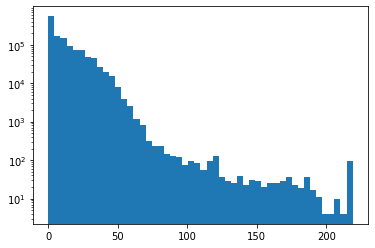

In [39]:
plt.hist(authors_careers['deltaYear'], bins=50)
plt.yscale('log')

In [40]:
authors_careers

,authorId,beginYear,wos_begin,lastYear,wos_last,deltaYear
0,18161,2008,[[Marine & Freshwater Biology]],2019,"[[Environmental Sciences], [Marine & Freshwate...",11
1,20361,1999,[[Neurosciences]],2004,"[[Biochemistry & Molecular Biology, Biophysics]]",5
2,39506,2010,"[[Neurosciences, Clinical Neurology, Gastroent...",2015,[[Cell Biology]],5
3,57623,2005,[[Respiratory System]],2009,"[[Respiratory System, Physiology]]",4
4,64128,2009,"[[Neurosciences, Clinical Neurology], [Neurosc...",2018,"[[Neurosciences, Behavioral Sciences]]",9
...,...,...,...,...,...,...
1290005,3035759232,2005,[[Neurosciences]],2019,[-1],14
1290006,3035760453,2012,[[Otorhinolaryngology]],2018,[-1],6
1290007,3035760604,2015,"[[Neurosciences], [Neurosciences]]",2015,"[[Neurosciences], [Neurosciences]]",0
1290008,3035761758,2008,"[[Neurosciences, Clinical Neurology]]",2018,"[[Behavioral Sciences, Neurosciences]]",10


In [46]:
# merge the careers with the original author file
authorsInPapers = pd.merge(authorsInPapers, authors_careers, on='authorId', how='left')

In [47]:
# save the file
authorsInPapers.to_csv(f'{path_output}collabNet_nodes2.csv', sep=';', index=False)

## Build the parametrized temporal collaboration network
Build a temporal multilayer network with AI and non-AI collaborations. Therefore two authors can be linked in different way, either 'AI' or 'nonAI' with time.

In [ ]:
# NEUROAI
cn = {}
for y in tqdm(range(1970,2020)):
    for authors in papersAI[papersAI['publicationYear']==y]['authors']:
        if eval(authors) != -1:
            a = list(set(eval(authors))) # to avoid the case where authors appear twice in a single publication
            for i in range(len(a)-1):
                for j in range(i+1,len(a)):
                    if (a[i],a[j],y) in cn:
                        cn[(a[i],a[j],y)][0] += 1
                    elif (a[j],a[i],y) in cn:
                        cn[(a[j],a[i],y)][0] += 1
                    else:
                        cn[(a[i],a[j],y)] = [1,0]
print('NeuroAI ok')
# NEURO
for y in tqdm(set(papersNonAI['publicationYear'])):
    for authors in papersNonAI[papersNonAI['publicationYear']==y]['authors']:
        if eval(authors)!=-1:
            a = list(set(eval(authors))) # to avoid the case where authors appear twice in a single publication
            for i in range(len(a)-1):
                for j in range(i+1,len(a)):
                    if (a[i],a[j],y) in cn:
                        cn[(a[i],a[j],y)][1] += 1
                    elif (a[j],a[i],y) in cn:
                        cn[(a[j],a[i],y)][1] += 1
                    else:
                        cn[(a[i],a[j],y)] = [0,1]
print('Neuro ok')
collabNet = [(i,j,y,k,l) for ((i,j,y),[k,l]) in cn.items()]
collabNet = pd.DataFrame.from_records(collabNet, columns=['author1','author2','year','w_AI','w_nonAI'])
collabNet['w'] = [i+j for i,j in zip(collabNet['w_nonAI'],collabNet['w_AI'])]

In [ ]:
# confirmation
a1, a2, y = 2153041777, 20660026, 1973
# avoid doublons
print(a1 in list(collabNet[collabNet['author1']==a2]['author2']))
# verify the variables 'w_AI' and 'w_nonAI'
ids = set(allpapers[(allpapers['authors']==a1)]['id']) & set(allpapers[allpapers['authors']==a2]['id'])
allpapers[(allpapers['id'].isin(ids)) 
          & (allpapers['publicationYear']==y)
          & ((allpapers['authors']==a1)|(allpapers['authors']==a2))]

In [ ]:
collabNet.to_csv(f'{path_output}collabNet_edges_2.csv', sep=';', index=False)
collabNet.rename(columns={'author1':'source','author2':'target'}).to_csv(f'{path_output}collabNet_edges_2_gephi.csv', sep=';', index=False)

## Build the time aggregated collaboration network

In [ ]:
# add weights
def aggregate(temporal_collab_network):
    cn = {}
    for i,j,w in tqdm(temporal_collab_network[['author1','author2','w']].values):
        if (i,j) in cn:
            cn[(i,j)] += w
        elif (j,i) in cn:
            cn[(j,i)] += w
        else:
            cn[(i,j)] = w
    cn = pd.DataFrame.from_records([(i,j,k) for ((i,j),k) in cn.items()], columns=['author1','author2','w'])
    return cn

In [ ]:
collabNet_timeagg = aggregate(collabNet)

#### Verification by comparing to the weights of the original network

In [226]:
ind = np.where(collabNet_timeagg['w']==max(collabNet_timeagg['w']))
collabNet_timeagg.loc[ind]

,author1,author2,w
331035,2737824110,2999599514,297


In [228]:
sum(collabNet[((collabNet['author1']==2737824110) & (collabNet['author2']==2999599514))|
              ((collabNet['author2']==2737824110) & (collabNet['author1']==2999599514))]['w'])

297

In [ ]:
collabNet_timeagg.to_csv(f'{path_output}collabNet_edges_timeagg.csv', sep=';', index=False)

# Comparison of different time-aggregated collaboration networks when applying different filters
Compare:
- their density, 
- their number of connected components and the distribution of their corresponding sizes 

In [17]:
# add weights
def aggregate(temporal_collab_network):
    cn = {}
    for i,j,w in tqdm(temporal_collab_network[['author1','author2','w']].values):
        if (i,j) in cn:
            cn[(i,j)] += w
        elif (j,i) in cn:
            cn[(j,i)] += w
        else:
            cn[(i,j)] = w
    cn = pd.DataFrame.from_records([(i,j,k) for ((i,j),k) in cn.items()], columns=['author1','author2','w'])
    return cn

#### Original time aggregated network with all the authors of the original database

In [18]:
collabNet_timeagg = aggregate(collabNet)

100%|███████████████████████████| 12637315/12637315 [00:19<00:00, 659249.46it/s]


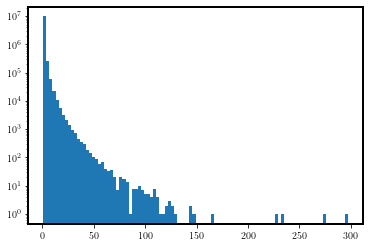

In [229]:
plt.hist(collabNet_timeagg['w'],bins=100)
plt.yscale('log')

In [230]:
G = ig.Graph.DataFrame(collabNet_timeagg, directed=False)

In [231]:
len(G.vs)

1278468

In [232]:
len(G.es)

10109269

In [233]:
G.density()

1.2370018924904797e-05

In [234]:
comp = [c for c in G.components()]
sizes = [len(c) for c in comp]

In [235]:
sorted(sizes)[-10:]

[30, 31, 31, 32, 32, 32, 34, 39, 41, 1166044]

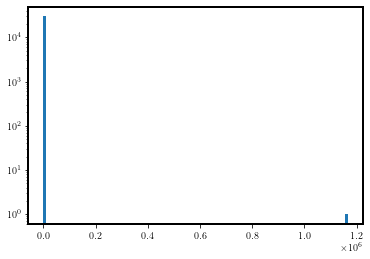

In [236]:
plt.hist(sizes,bins=100)
plt.yscale('log')

### Select only the authors having at least 3 publications

In [268]:
authorsInPapers_sub = authorsInPapers[authorsInPapers['nb_publi_all']>=3]

In [278]:
len(authorsInPapers_sub)

899706

In [269]:
sub_collabNet_timeagg = collabNet_timeagg[collabNet_timeagg['author1'].isin(authorsInPapers_sub['authorId'])
                         & collabNet_timeagg['author2'].isin(authorsInPapers_sub['authorId'])]

In [270]:
G = ig.Graph.DataFrame(sub_collabNet_timeagg, directed=False)

In [271]:
len(G.vs)

887227

In [350]:
887227/len(authorsInPapers)

0.6876977012590096

In [272]:
len(G.es)

7819355

In [273]:
G.density()

1.986698282284764e-05

In [274]:
comp = [c for c in G.components()]
sizes = [len(c) for c in comp]

In [275]:
len(comp)

16561

In [276]:
sorted(sizes)[-10:]

[24, 25, 25, 26, 27, 27, 28, 29, 30, 828240]

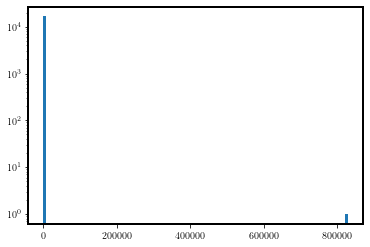

In [277]:
plt.hist(sizes,bins=100)
plt.yscale('log')

### Select only the authors with bounded careers

In [237]:
#authorsInPapers_sub = authorsInPapers[authorsInPapers['nb_publi_all']>=3]

In [249]:
sub_collabNet_timeagg = collabNet_timeagg[collabNet_timeagg['author1'].isin(authors_careers_sub['authorId'])
                         & collabNet_timeagg['author2'].isin(authors_careers_sub['authorId'])]

In [250]:
G = ig.Graph.DataFrame(sub_collabNet_timeagg, directed=False)

In [251]:
len(G.vs)

1261059

In [252]:
len(G.es)

9641832

In [253]:
G.density()

1.2126042558122171e-05

In [254]:
comp = [c for c in G.components()]
sizes = [len(c) for c in comp]

In [257]:
len(comp)

32284

In [255]:
sorted(sizes)[-10:]

[31, 32, 32, 32, 34, 34, 39, 41, 45, 1140463]

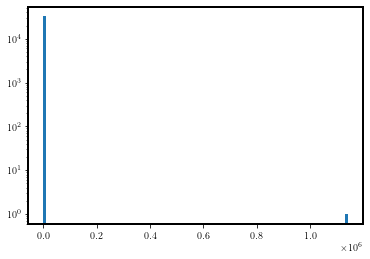

In [256]:
plt.hist(sizes,bins=100)
plt.yscale('log')

### Select only the authors with bounded careers and having at least 3 publications

In [20]:
authorsInPapers_sub = authorsInPapers[(authorsInPapers['nb_publi_all']>=3) &
                                      (authorsInPapers['authorId'].isin(authors_careers_sub['authorId']))]

In [20]:
sub_collabNet_timeagg = collabNet_timeagg[collabNet_timeagg['author1'].isin(authorsInPapers_sub['authorId'])
                         & collabNet_timeagg['author2'].isin(authorsInPapers_sub['authorId'])]

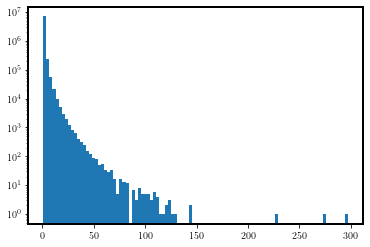

In [61]:
plt.hist(sub_collabNet_timeagg['w'],bins=100)
plt.yscale('log')

In [215]:
G = ig.Graph.DataFrame(sub_collabNet_timeagg, directed=False)

In [217]:
len(G.vs)

871282

In [218]:
len(G.es)

7420423

In [220]:
sum(sub_collabNet_timeagg['w'])

10785916

In [216]:
len(G.vs)/len(authorsInPapers)

0.6753385870226588

In [407]:
# share of removing edges
(sum(collabNet_timeagg['w'])-sum(sub_collabNet_timeagg['w']))/sum(collabNet_timeagg['w'])

0.2176531209689165

In [299]:
G.density()

1.9549770933834205e-05

In [242]:
comp = [c for c in G.components()]
sizes = sorted([len(c) for c in comp])

In [237]:
ind_sorted

array([8799, 5840, 5839, ..., 7410, 1192,    0])

In [222]:
len(comp)

17599

In [302]:
sorted(sizes)[-10:]

[25, 26, 27, 27, 27, 28, 28, 29, 30, 809280]

In [303]:
sum(sizes[:-1])

62002

In [408]:
# share of nodes in independent connected components, here 7.7%
62002/809280

0.07661378015025702

In [223]:
sizes[-1]/len(G.vs)

0.9288381947521009

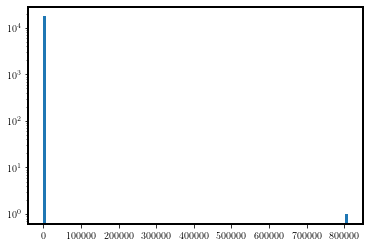

In [304]:
plt.hist(sizes,bins=100)
plt.yscale('log')

#### Who are the problematic persons? 
Compare with the percentage of persons making AI wrt to the AI score vs nb_publi_all

In [62]:
authorsInPapers_reject = authorsInPapers[~((authorsInPapers['nb_publi_all']>=3) &
                                           (authorsInPapers['authorId'].isin(authors_careers_sub['authorId'])))]
authorsInPapers_reject

,authorId,name,affiliation,queryLevel,nb_publi_neuro,AIscore_neuro,nb_publi_all,AIscore_all
2,2806045187,A.A.A. Pradhan,5023651,0.0,1.0,0.0,1,0.0
3,2974182613,A. A. Aarnisalo,NONE,0.0,1.0,0.0,2,0.0
5,2840631567,A A Abdel-Rahman,1309191912,0.0,1.0,0.0,1,0.0
6,2639413062,A.A. Acheampong,201448701,0.0,1.0,1.0,1,1.0
8,2437395452,A A Ajayi,45711476,0.0,1.0,0.0,1,0.0
...,...,...,...,...,...,...,...,...
1290136,2263707641,Е. Viteva,NONE,0.0,1.0,0.0,1,0.0
1290137,3022633000,Е Е Garanina,21203515,0.0,1.0,0.0,1,0.0
1290138,2688406403,Мikhail Pashenkov,NONE,0.0,1.0,0.0,1,0.0
1290139,2495571327,І. L. Popovych,149851306,0.0,1.0,0.0,1,0.0


In [420]:
np.quantile(authorsInPapers_reject['AIscore_all'],q=0.97)

0.011696180341563714

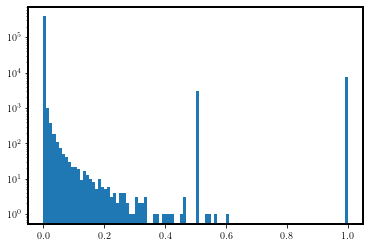

In [325]:
plt.hist(authorsInPapers_reject['AIscore_all'],bins=100)
plt.yscale('log')

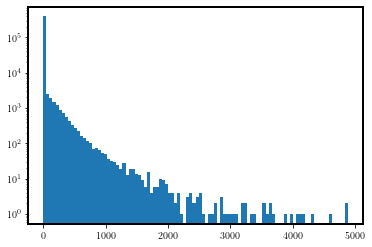

In [331]:
plt.hist(authorsInPapers_reject['nb_publi_all'],bins=100)
plt.yscale('log')

In [409]:
# share of authors having AIscore_all=1 in the rejected wrt to the whole set
len(authorsInPapers_reject[authorsInPapers_reject['AIscore_all']==1])/len(authorsInPapers[authorsInPapers['AIscore_all']==1])

0.945664739884393

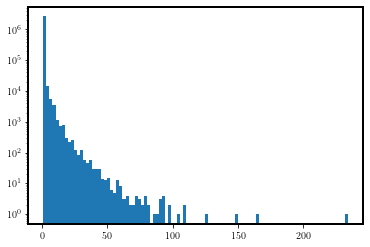

In [349]:
plt.hist(collabNet_timeagg[collabNet_timeagg['author1'].isin(authorsInPapers_reject['authorId'])|
                  collabNet_timeagg['author2'].isin(authorsInPapers_reject['authorId'])]['w'], bins= 100)
plt.yscale('log')

Results: removing the problematic researchers from the whole collaboration network rejects 21.8% of the edges and keeps only 67.5% of the authors. Though the weight distribution is not altered on little values, only some rare values disappears at the end of the queue. According to the results below, they are mainly publishing in pure neuroscience not AI (to prove) and around 97% of them have an AI_score lower than 1% among their total number of publications. 

#### Check the potential loss of the time collaboration network in AI research if we remove the problematic authors in it

In [119]:
papersAI['authors'] = papersAI['authors'].apply(lambda x: eval(x))

In [68]:
# share of authors in the subset having complete carrer and at least 3 publications
len(set(papersAI.explode('authors')['authors'])&set(authors_careers_sub['authorId']))/len(set(papersAI.explode('authors')['authors']))

0.9826337773628715

In [69]:
1-0.9826337773628715

0.017366222637128503

In [67]:
# who are the rejected ones?
authors_rejected = set(papersAI.explode('authors')['authors'])-set(authors_careers_sub['authorId'])
authors_rejected = authors_careers[authors_careers['authorId'].isin(authors_rejected)]
authors_rejected

,authorId,beginYear,wos_begin,lastYear,wos_last,deltaYear
1190,16708460,1965,[-1],2018,[-1],53
2008,27601079,1960,[-1],2019,"[[Zoology], [Multidisciplinary Sciences], [Psy...",59
5215,73820803,1963,"[[Acoustics, Audiology & Speech-Language Patho...",2019,[[Psychology]],56
6938,98431680,1966,[-1],2019,"[-1, [Telecommunications, Engineering, Compute...",53
8274,118171638,1962,"[[Cell Biology, Biochemistry & Molecular Biolo...",2019,"[[Clinical Neurology, Psychiatry, Neuroimaging]]",57
...,...,...,...,...,...,...
1288275,3034041981,1952,"[-1, -1]",2018,"[[Neurosciences, Psychiatry], [Clinical Neurol...",66
1288379,3034173479,1966,"[[Cell Biology, Physiology]]",2019,[[Neurosciences]],53
1289210,3034977899,1957,[-1],2019,"[[Pharmacology & Pharmacy, Genetics & Heredity...",62
1289401,3035170736,1953,[[Clinical Neurology]],2019,"[[Health Policy & Services], [Surgery, Clinica...",66


(array([  1., 308., 234., 100., 161., 100.,  42.,  64.,  44.,  21.,  37.,
         41.,  19.,   5.,  10.,  14.,   7.,   7.,  12.,   4.,   9.,   8.,
         15.,   5.,   5.,   7.,   3.,   3.,   6.,   2.,   2.,   1.,   6.,
          1.,   5.,   7.,   1.,   4.,   8.,   1.,   4.,  21.,   2.,   2.,
          1.,   2.,   0.,   0.,   2.,   3.,   1.,   2.,   2.,   2.,   1.,
          2.,   2.,   2.,   5.,   1.,   0.,   1.,   3.,   2.,   1.,   0.,
          2.,   1.,   3.,   0.,   0.,   2.,   0.,   0.,   1.,   6.,   1.,
          6.,   1.,   1.,   2.,   3.,   0.,   1.,   0.,   2.,   0.,   0.,
          2.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   1.,   0.,
         17.]),
 array([ 49. ,  50.7,  52.4,  54.1,  55.8,  57.5,  59.2,  60.9,  62.6,
         64.3,  66. ,  67.7,  69.4,  71.1,  72.8,  74.5,  76.2,  77.9,
         79.6,  81.3,  83. ,  84.7,  86.4,  88.1,  89.8,  91.5,  93.2,
         94.9,  96.6,  98.3, 100. , 101.7, 103.4, 105.1, 106.8, 108.5,
        110.2, 111.9, 113.6, 115.3

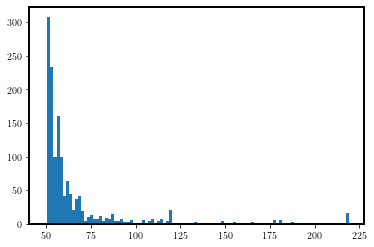

In [70]:
plt.hist(authors_rejected['deltaYear'],bins=100)
#plt.yscale('log')

0.09179494957154774


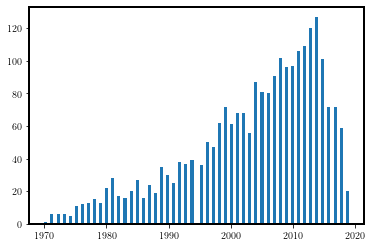

In [403]:
# when are situated their main publications?
p = papersAI.explode('authors')
publis = p[p['authors'].isin(authors_rejected['authorId'])].drop_duplicates('id')
plt.hist(publis['publicationYear'],bins=100)
print(len(publis)/len(set(papersAI['id'])))

In [389]:
meta_authors_rejected = authorsInPapers[authorsInPapers['authorId'].isin(authors_rejected['authorId'])]

(array([ 59., 164., 143., 160., 137., 128.,  90.,  64.,  76.,  54.,  49.,
         42.,  33.,  27.,  17.,  24.,  18.,  21.,  20.,   8.,   5.,  13.,
         10.,   8.,   5.,   3.,   6.,   5.,   2.,   4.,   4.,   4.,   4.,
          2.,   4.,   3.,   1.,   1.,   4.,   1.,   4.,   1.,   0.,   0.,
          2.,   1.,   0.,   0.,   0.,   1.,   0.,   1.,   1.,   0.,   0.,
          1.,   1.,   0.,   2.,   1.,   1.,   0.,   1.,   0.,   0.,   0.,
          0.,   0.,   1.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   1.,   0.,   0.,   1.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          2.]),
 array([2.00000e+00, 5.08100e+01, 9.96200e+01, 1.48430e+02, 1.97240e+02,
        2.46050e+02, 2.94860e+02, 3.43670e+02, 3.92480e+02, 4.41290e+02,
        4.90100e+02, 5.38910e+02, 5.87720e+02, 6.36530e+02, 6.85340e+02,
        7.34150e+02, 7.82960e+02, 8.31770e+02, 8.80580e+02, 9.29390e+02,
        9.78200e+02, 1.027

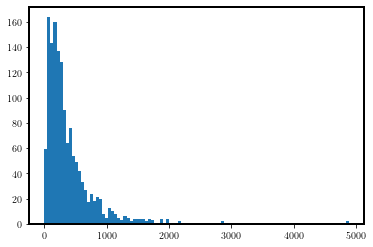

In [390]:
# check the distribution of the number of publications
plt.hist(meta_authors_rejected['nb_publi_all'],bins=100)
#plt.yscale('log')

(array([427., 324., 195., 119.,  62.,  43.,  34.,  37.,  23.,  22.,  19.,
          9.,   9.,   8.,   7.,   5.,   3.,   1.,   5.,   6.,   3.,   3.,
          5.,   8.,   1.,   6.,   1.,   1.,   3.,   5.,   3.,   2.,   4.,
          2.,   2.,   1.,   1.,   3.,   3.,   0.,   0.,   0.,   2.,   1.,
          2.,   1.,   1.,   1.,   1.,   0.,   1.,   1.,   1.,   1.,   0.,
          0.,   2.,   1.,   0.,   2.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.,   0.,   0.,   0.,   0.,   1.,   1.,   0.,   0.,   1.,   0.,
          0.,   0.,   1.,   0.,   1.,   2.,   0.,   0.,   0.,   0.,   0.,
          3.,   0.,   0.,   0.,   0.,   0.,   1.,   1.,   0.,   0.,   0.,
          1.]),
 array([0.00067705, 0.00634038, 0.01200371, 0.01766705, 0.02333038,
        0.02899371, 0.03465704, 0.04032038, 0.04598371, 0.05164704,
        0.05731037, 0.06297371, 0.06863704, 0.07430037, 0.0799637 ,
        0.08562704, 0.09129037, 0.0969537 , 0.10261704, 0.10828037,
        0.1139437 , 0.11960703, 0.12527037, 0.

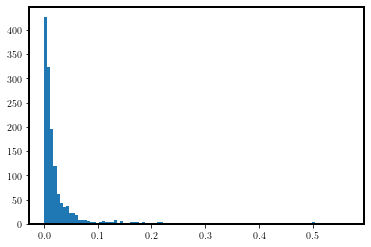

In [391]:
plt.hist(meta_authors_rejected['AIscore_all'],bins=100)
#plt.yscale('log')

In [354]:
# study the sub collaboration network in AI
cn = {}
for y in tqdm(range(1970,2020)):
    for authors in papersAI[papersAI['publicationYear']==y]['authors']:
        if eval(authors) != -1:
            a = list(set(eval(authors))) # to avoid the case where authors appear twice in a single publication
            for i in range(len(a)-1):
                for j in range(i+1,len(a)):
                    if (a[i],a[j],y) in cn:
                        cn[(a[i],a[j],y)] += 1
                    elif (a[j],a[i],y) in cn:
                        cn[(a[j],a[i],y)] += 1
                    else:
                        cn[(a[i],a[j],y)] = 1
collabNet_NeuroAI = [(i,j,y,k) for ((i,j,y),k) in cn.items()]
collabNet_NeuroAI = pd.DataFrame.from_records(collabNet_NeuroAI, columns=['author1','author2','year','w'])

100%|███████████████████████████████████████████| 50/50 [00:00<00:00, 91.39it/s]


In [375]:
# share of total links of the subgraph of AI research if we remove problematic authors publishing in it
sum(collabNet_NeuroAI[collabNet_NeuroAI['author1'].isin(authors_careers_sub['authorId'])&
                  collabNet_NeuroAI['author2'].isin(authors_careers_sub['authorId'])]['w'])/sum(collabNet_NeuroAI['w'])

0.9562142020028528

Results: the authors that have been removed in this little subset are not much driving the whole research of AI in neuroscience. They represents 1.7% of the subset of authors over only 9.2% of the publications of the subset $\mathcal{P}\cap AI$. Removing them from the collaboration network conserves 95.6% of it.